# Descripción del proyecto

Rusty Bargain es un servicio de venta de coches de segunda mano que está desarrollando una app para atraer a nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial, especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.

A Rusty Bargain le interesa:

- la calidad de la predicción
- la velocidad de la predicción
- el tiempo requerido para el entrenamiento

## Instrucciones del proyecto

1. Descarga y examina los datos.
2. Entrena diferentes modelos con varios hiperparámetros (debes hacer al menos dos modelos diferentes, pero más es mejor. 3. Recuerda, varias implementaciones de potenciación del gradiente no cuentan como modelos diferentes). El punto principal de este paso es comparar métodos de potenciación del gradiente con bosque aleatorio, árbol de decisión y regresión lineal.
4. Analiza la velocidad y la calidad de los modelos.

## Observaciones:

- Utiliza la métrica RECM para evaluar los modelos.
- La regresión lineal no es muy buena para el ajuste de hiperparámetros, pero es perfecta para hacer una prueba de cordura de otros métodos. Si la potenciación del gradiente funciona peor que la regresión lineal, definitivamente algo salió mal.
- Aprende por tu propia cuenta sobre la librería LightGBM y sus herramientas para crear modelos de potenciación del gradiente (gradient boosting).
- Idealmente, tu proyecto debe tener regresión lineal para una prueba de cordura, un algoritmo basado en árbol con ajuste de hiperparámetros (preferiblemente, bosque aleatorio), LightGBM con ajuste de hiperparámetros (prueba un par de conjuntos), y CatBoost y XGBoost con ajuste de hiperparámetros (opcional).
- Toma nota de la codificación de características categóricas para algoritmos simples. LightGBM y CatBoost tienen su implementación, pero XGBoost requiere OHE.
- Puedes usar un comando especial para encontrar el tiempo de ejecución del código de celda en Jupyter Notebook. Encuentra ese comando.
- Dado que el entrenamiento de un modelo de potenciación del gradiente puede llevar mucho tiempo, cambia solo algunos parámetros del modelo.
- Si Jupyter Notebook deja de funcionar, elimina las variables excesivas por medio del operador del:
  
## Descripción de los datos

### Características

- DateCrawled — fecha en la que se descargó el perfil de la base de datos
- VehicleType — tipo de carrocería del vehículo
- RegistrationYear — año de matriculación del vehículo
- Gearbox — tipo de caja de cambios
- Power — potencia (CV)
- Model — modelo del vehículo
- Mileage — kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)
- RegistrationMonth — mes de matriculación del vehículo
- FuelType — tipo de combustible
- Brand — marca del vehículo
- NotRepaired — vehículo con o sin reparación
- DateCreated — fecha de creación del perfil
- NumberOfPictures — número de fotos del vehículo
- PostalCode — código postal del propietario del perfil (usuario)
- LastSeen — fecha de la última vez que el usuario estuvo activo

### Objetivo

Price — precio (en euros)
 
## Evaluación del proyecto

Hemos definido los criterios de evaluación para el proyecto. Léelos con atención antes de pasar al ejercicio.

Esto es en lo que se fijarán los revisores al examinar tu proyecto:

- ¿Seguiste todos los pasos de las instrucciones?
- ¿Cómo preparaste los datos?
- ¿Qué modelos e hiperparámetros consideraste?
- ¿Conseguiste evitar la duplicación del código?
- ¿Cuáles son tus hallazgos?
- ¿Mantuviste la estructura del proyecto?
- ¿Mantuviste el código ordenado?
- Ya tienes tus hojas informativas y los resúmenes de los capítulos, por lo que todo está listo para continuar con el proyecto

# Librerias

In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy import stats as st
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
import sklearn.linear_model
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import sklearn.preprocessing
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from IPython.display import display
from scipy.spatial import distance
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    r2_score,mean_squared_error
)
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor
import xgboost as xgb
import joblib

# Cargue y limpieza de datos

In [174]:
df=pd.read_csv('datasets/car_data.csv')
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [176]:
#df=df.sample(1000,random_state=12345)

In [177]:
#Funcion para pasar columnas al formato snake_case
def to_snake_case(name):
    s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', name)
    s1 = s1.replace(' ','_')
    return re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower()

In [178]:
#Pasamos las columnas al modo snake_case
columns=df.columns
new_cols=[]
for i in columns:
    i=to_snake_case(i)
    new_cols.append(i)
df.columns=new_cols
print(df.columns)

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'mileage', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen'],
      dtype='object')


In [179]:
#Pasamos datos categoricos a texto
df['postal_code']=df['postal_code'].astype('str')


In [180]:
df.drop(['date_crawled','date_created','number_of_pictures','last_seen','postal_code'],axis=1,inplace=True)

In [181]:
df.describe()

,price,registration_year,power,mileage,registration_month
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645
std,4514.158514,90.227958,189.850405,37905.341530,3.726421
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


Desde el $ df.info $ podemos ver bastantes diferencias entre columnas lo que puede significar en valores ausentes, lo cual ya veremos más a fondo.

## Ausentes

In [182]:
#Calculamos el número de ausentes
print('Porcentaje de significancia:\n',df.isna().sum())

Porcentaje de significancia:
 price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
mileage                   0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
dtype: int64


In [183]:
#Calculamos el porcentaje de significancia de los ausentes
print('Porcentaje de significancia: \n',df.isna().sum()/df.shape[0])

Porcentaje de significancia: 
 price                 0.000000
vehicle_type          0.105794
registration_year     0.000000
gearbox               0.055967
power                 0.000000
model                 0.055606
mileage               0.000000
registration_month    0.000000
fuel_type             0.092827
brand                 0.000000
not_repaired          0.200791
dtype: float64


In [184]:
def nan_values(data):
    # Tratamiento de ausentes
    null_cols=['vehicle_type','gearbox','model','fuel_type','not_repaired']
    for column in null_cols:   
        if data[column].isna().sum()/data.shape[0] < 0.15:
            mode=data[column].mode()[0]
            data[column].fillna(value=mode,inplace=True)
        elif data[column].isna().sum()/data.shape[0] > 0.15:
            data.dropna(inplace=True)
        return data

In [185]:
df=nan_values(df)

In [186]:
#Calculamos el porcentaje de significancia de los ausentes
print('Porcentaje de significancia: \n',100*df.isna().sum()/df.shape[0])

Porcentaje de significancia: 
 price                  0.000000
vehicle_type           0.000000
registration_year      0.000000
gearbox                5.596709
power                  0.000000
model                  5.560588
mileage                0.000000
registration_month     0.000000
fuel_type              9.282697
brand                  0.000000
not_repaired          20.079070
dtype: float64


Vemos una gran cantidad de valores ausentes para la columna 'not_repaired' por lo tanto los vamos a eliminar, y el resto de columnas los imputaremos con el valor de la moda.

In [187]:
null_cols=['vehicle_type','gearbox','model','fuel_type']
for col in null_cols:
    mode=df[col].mode()[0]
    df[col].fillna(value=mode,inplace=True)
    print(df[col].isna().sum())


0
0
0
0


In [188]:
#Calculamos el porcentaje de significancia de los ausentes
print('Porcentaje de significancia: \n',100*df.isna().sum()/df.shape[0])

Porcentaje de significancia: 
 price                  0.00000
vehicle_type           0.00000
registration_year      0.00000
gearbox                0.00000
power                  0.00000
model                  0.00000
mileage                0.00000
registration_month     0.00000
fuel_type              0.00000
brand                  0.00000
not_repaired          20.07907
dtype: float64


In [189]:
df.dropna(inplace=True)

Aplicamos nuestras técnicas para eliminar los valores ausentes.

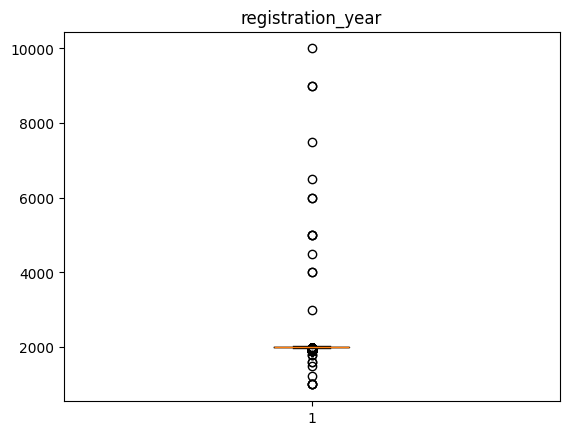

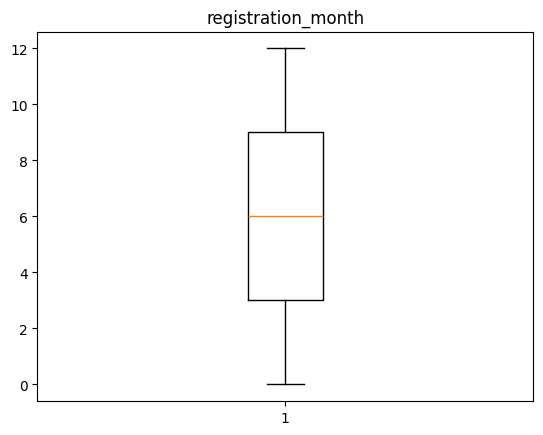

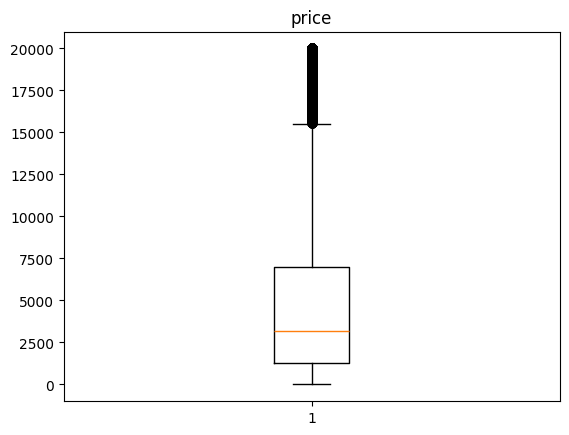

In [190]:
numeric=['registration_year','registration_month','price']
for column in numeric:
    plt.boxplot(df[column])
    plt.title(column)   
    plt.show()

Podemos ver varios datos atipicos en el año de registro, debido a que hay años mayores a la fecha actual, debemos reemplazarlos. De la misma manera debemos tener en cuenta los precios de los carros que son iguales a cero, debido a que no tiene sentido, los reemplazaremos con la media.

In [191]:

df['registration_year'][df['registration_year']==0]

Series([], Name: registration_year, dtype: int64)

In [192]:
df['registration_year'][df['registration_year']>2024]=0

C:\Users\Santiago\AppData\Local\Temp\ipykernel_7900\1874769975.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['registration_year'][df['registration_year']>2024]=0


In [193]:
df['registration_year']=df['registration_year'].replace(0,df['registration_year'].mean())
df['price']=df['price'].replace(0,df['price'].mean())

In [194]:
df['registration_year']=df['registration_year'].astype('str')
df['registration_month']=df['registration_month'].astype('str')
df['price']=df['price'].astype('int')


In [195]:
numeric=['registration_year','registration_month','price']
for column in numeric:
   print(df[column].value_counts())

registration_year
1999.0    17879
2005.0    17657
2006.0    17623
2000.0    17204
2003.0    16686
          ...  
1941.0        1
1936.0        1
1933.0        1
1925.0        1
1600.0        1
Name: count, Length: 99, dtype: int64
registration_month
3     29548
6     26418
4     24778
5     24382
7     22914
10    22051
11    20557
12    20301
9     20150
1     19659
8     19091
2     18110
0     15256
Name: count, dtype: int64
price
4866     5484
1500     4147
500      4086
2500     3489
1200     3463
         ... 
12660       1
1208        1
633         1
1496        1
14989       1
Name: count, Length: 3506, dtype: int64


## Duplicados

In [196]:
#Calculamos el porcentaje de significancia de los ausentes
print('Total duplicados: \n',df.duplicated().sum())

Total duplicados: 
 23826


In [197]:
#Calculamos el porcentaje de significancia de los ausentes
print('Total duplicados: \n',100*df.duplicated().sum()/df.shape[0])

Total duplicados: 
 8.412690005825963


Al tener un porcentaje de datos duplicados tan bajo, optamos por eliminarlos

In [198]:
df.drop_duplicates(inplace=True)

In [199]:
#Calculamos el porcentaje de significancia de los ausentes
print('Total duplicados: \n',100*df.duplicated().sum()/df.shape[0])

Total duplicados: 
 0.0


# Entrenamiento

## Separamos los datos de entrenamiento y validación

In [200]:
categorical=['vehicle_type', 'registration_year', 'gearbox',
       'model', 'registration_month', 'fuel_type', 'brand',
       'not_repaired']
seed=12345
features=df.drop(['price'],axis=1)
target=df['price']
features_oh=pd.get_dummies(features[categorical],drop_first=True)
features_train,features_valid,target_train,target_valid=train_test_split(features,target,test_size=0.25,random_state=seed)
features_train_oh,features_valid_oh,target_train_oh,target_valid_oh=train_test_split(features_oh,target,test_size=0.25,random_state=seed)

## Modelos con potenciación del gradiente

### Catboost Regressor

In [201]:
features_train.info()
features_train.columns

<class 'pandas.core.frame.DataFrame'>
Index: 194541 entries, 226724 to 293562
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   vehicle_type        194541 non-null  object
 1   registration_year   194541 non-null  object
 2   gearbox             194541 non-null  object
 3   power               194541 non-null  int64 
 4   model               194541 non-null  object
 5   mileage             194541 non-null  int64 
 6   registration_month  194541 non-null  object
 7   fuel_type           194541 non-null  object
 8   brand               194541 non-null  object
 9   not_repaired        194541 non-null  object
dtypes: int64(2), object(8)
memory usage: 16.3+ MB


Index(['vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'mileage', 'registration_month', 'fuel_type', 'brand', 'not_repaired'],
      dtype='object')

In [202]:
grid = {'iterations': [50],
    'learning_rate': [0.03, 0.1],
    'depth':[4, 6, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}

In [203]:
%%time

#Entrenamos el modelo
features_total=['vehicle_type', 'registration_year', 'gearbox', 'power', 'model',
       'mileage', 'registration_month', 'fuel_type', 'brand', 'not_repaired']
features_cat=['vehicle_type', 'registration_year', 'gearbox', 'model', 'registration_month', 'fuel_type', 'brand', 'not_repaired']
train_pool = Pool(features_train[features_total], label=target_train, cat_features=features_cat)
valid_pool = Pool(features_valid[features_total], label=target_valid, cat_features=features_cat)
model_cat=CatBoostRegressor(loss_function='RMSE',random_seed=seed)
grid_search_cat=model_cat.grid_search(grid, train_pool, shuffle=False,verbose=3)
best_params=grid_search_cat['params']
print(best_params)

KeyboardInterrupt: 

In [ ]:
#Evaluamos el modelo

best_model = CatBoostRegressor(**best_params)
best_model.fit(train_pool, eval_set=valid_pool, verbose=10)
predictions = best_model.predict(valid_pool)
r2_rmse = r2_score(target_valid, predictions)
rmse_score_rmse_model = np.sqrt(mean_squared_error(target_valid, predictions))
print('R2 score: {:.3f}\nRMSE score: {:.2f}'.format(r2_rmse, rmse_score_rmse_model))

0:	learn: 4294.1033276	test: 4268.2552431	best: 4268.2552431 (0)	total: 129ms	remaining: 6.33s
10:	learn: 2616.7320490	test: 2591.9616725	best: 2591.9616725 (10)	total: 1.29s	remaining: 4.58s
20:	learn: 2121.7200124	test: 2104.7513727	best: 2104.7513727 (20)	total: 2.59s	remaining: 3.57s
30:	learn: 1927.4027488	test: 1915.1414871	best: 1915.1414871 (30)	total: 3.79s	remaining: 2.32s
40:	learn: 1858.4172722	test: 1854.9972097	best: 1854.9972097 (40)	total: 4.95s	remaining: 1.08s
49:	learn: 1821.9446702	test: 1825.1746428	best: 1825.1746428 (49)	total: 5.97s	remaining: 0us

bestTest = 1825.174643
bestIteration = 49

R2 score: 0.842
RMSE score: 1825.17


In [ ]:
joblib.dump(best_model,'models/model_cat.joblib')

['models/model_cat.joblib']

In [ ]:
categorical_features = ['vehicle_type', 'registration_year', 'gearbox', 'model', 'registration_month', 'fuel_type', 'brand', 'not_repaired']
for i in categorical_features:
    features_train[categorical_features]=features_train[categorical_features].astype('category')
    features_valid[categorical_features]=features_valid[categorical_features].astype('category')

In [ ]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194541 entries, 226724 to 293562
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   vehicle_type        194541 non-null  category
 1   registration_year   194541 non-null  category
 2   gearbox             194541 non-null  category
 3   power               194541 non-null  int64   
 4   model               194541 non-null  category
 5   mileage             194541 non-null  int64   
 6   registration_month  194541 non-null  category
 7   fuel_type           194541 non-null  category
 8   brand               194541 non-null  category
 9   not_repaired        194541 non-null  category
dtypes: category(8), int64(2)
memory usage: 6.1 MB


## Light gbm sin optimizar hiperparametros

In [ ]:
params = {
    'objective': 'regression',
    'metric': 'rmse'
    }

In [ ]:
%%time

categorical_features = ['vehicle_type', 'registration_year', 'gearbox', 'model', 'registration_month', 'fuel_type', 'brand', 'not_repaired']
lgb_train_features=lgb.Dataset(features_train,label=target_train,categorical_feature=categorical_features)
lgb_valid_features=lgb.Dataset(features_valid,label=target_valid,reference=lgb_train_features)
#Entrenamos el modelo
model_lgbm=lgb.train(params,lgb_train_features,valid_sets=[lgb_train_features, lgb_valid_features])

prediction = model_lgbm.predict(features_valid)
# Evaluamos el modelo
r2_rmse = r2_score(target_valid, prediction)
rmse_score_rmse_model = np.sqrt(mean_squared_error(target_valid, prediction))
print('R2 score: {:.3f}\nRMSE score: {:.2f}'.format(r2_rmse, rmse_score_rmse_model))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 668
[LightGBM] [Info] Number of data points in the train set: 194541, number of used features: 10
[LightGBM] [Info] Start training from score 4951.077511


R2 score: 0.860
RMSE score: 1718.21
CPU times: total: 9.19 s
Wall time: 976 ms


In [ ]:
joblib.dump(model_lgbm,'models/model_lgbm.joblib')

['models/model_lgbm.joblib']

## Light gbm optimizando hiperparametros

In [ ]:
%%time

#Entrenamos el modelo
model_lg = lgb.LGBMRegressor(random_state=seed,force_col_wise=True)


param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [20, 30, 50]
}


grid = GridSearchCV(model_lg, param_grid, cv=3, scoring='r2')

grid.fit(features_train_oh, target_train_oh)

print("Mejores parametros:", grid.best_params_)
print("Mejores parametros: {:.2f}".format(grid.best_score_))
#Evaluamos el modelo
best_model = grid.best_estimator_
y_pred = best_model.predict(features_valid_oh)
rmse = mean_squared_error(target_valid, y_pred)**0.5
r2=r2_score(target_valid, y_pred)
print("RMSE:",rmse)
print('r2: ',r2)

[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 129694, number of used features: 348
[LightGBM] [Info] Start training from score 4948.495536
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 129694, number of used features: 348
[LightGBM] [Info] Start training from score 4963.684195
[LightGBM] [Info] Total Bins 692
[LightGBM] [Info] Number of data points in the train set: 129694, number of used features: 346
[LightGBM] [Info] Start training from score 4941.052801
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 129694, number of used features: 348
[LightGBM] [Info] Start training from score 4948.495536
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 129694, number of used features: 348
[LightGBM] [Info] Start training from score 4963.684195
[LightGBM] [Info] Total Bins 692
[LightGBM] [Info] Number of data points in the 

In [ ]:
joblib.dump(best_model,'models/model_lg.joblib')

['models/model_lg.joblib']

## XGBoost

In [ ]:
%%time
#Entrenamos los datos
dtrain=xgb.DMatrix(features_train_oh,label=target_train_oh)
dtest=xgb.DMatrix(features_valid_oh,label=target_valid_oh)
param = {'max_depth': 2, 'eta': 1, 'objective': 'reg:squarederror'}
param['nthread'] = 4
param['eval_metric'] = 'rmse'
evallist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)

#Evaluamos el modelo
y_pred = bst.predict(dtest)
xg_rmse=mean_squared_error(target_valid_oh,y_pred)**0.5
xg_r2=r2_score(target_valid_oh,y_pred)
print("RMSE:",xg_rmse)
print('r2: ',xg_r2)

c:\Users\Santiago\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-rmse:4295.55596	eval-rmse:4271.21881
[1]	train-rmse:4024.50011	eval-rmse:4004.28553
[2]	train-rmse:3775.79566	eval-rmse:3755.66997
[3]	train-rmse:3539.11010	eval-rmse:3518.21274
[4]	train-rmse:3341.80430	eval-rmse:3315.66062
[5]	train-rmse:3203.41131	eval-rmse:3172.50976
[6]	train-rmse:3086.15045	eval-rmse:3053.49825
[7]	train-rmse:3008.97830	eval-rmse:2978.32658
[8]	train-rmse:2933.77526	eval-rmse:2905.33291
[9]	train-rmse:2880.35873	eval-rmse:2854.74578
RMSE: 2854.745789051414
r2:  0.6136813707680361
CPU times: total: 18.5 s
Wall time: 2.84 s


In [ ]:
joblib.dump(bst,'models/bst.joblib')

['models/bst.joblib']

## Creamos pipelines de los modelos que vamos a evaluar

In [ ]:
#Escalamos nuestros datos
numeric=['power','mileage']
scaler=StandardScaler()
scaler.fit(features_train[numeric])
features_train_oh[numeric]=scaler.transform(features_train[numeric])
features_valid_oh[numeric]=scaler.transform(features_valid[numeric])


In [ ]:
# Comenzamos por los modelos sin potenciación del gradiente
pipe_rf=Pipeline([('rf',RandomForestRegressor())])
pipe_dt=Pipeline([('dt',DecisionTreeRegressor())])

params=[{'rf__max_depth':[3,4,2,1],
         'rf__min_samples_split':[5,10,11,12],
         'rf__n_estimators':[10,20,30,40],
         'rf__min_samples_leaf':[1, 2, 4],
         'rf__bootstrap':[True, False],
         'rf__max_features':[np.random.randint(1, 11)]},
         {'dt__max_depth': [3,4,2,1],
         'dt__max_features':[np.random.randint(1, 9)],
         'dt__min_samples_leaf': [1, 2, 4]},
         ]

In [ ]:
%%time
#Entrenamos nuestros modelos

pipes=[pipe_rf,pipe_dt]
for pipe,grid in zip(pipes,params):
    rs=RandomizedSearchCV(estimator=pipe,param_distributions=grid,scoring='r2',cv=2,random_state=seed)
    rs.fit(features_train_oh,target_train_oh)
    print(rs.best_params_)
    print(rs.best_score_)
    print(rs.best_estimator_)
    random_prediction = rs.best_estimator_.predict(features_valid_oh)
    random_rmse=mean_squared_error(target_valid_oh,random_prediction)**0.5
    random_r2=r2_score(target_valid,random_prediction)
    print("RMSE:",random_rmse)
    print('r2: ',random_r2)
    

{'rf__n_estimators': 30, 'rf__min_samples_split': 11, 'rf__min_samples_leaf': 2, 'rf__max_features': 2, 'rf__max_depth': 4, 'rf__bootstrap': False}
0.059336321345849874
Pipeline(steps=[('rf',
                 RandomForestRegressor(bootstrap=False, max_depth=4,
                                       max_features=2, min_samples_leaf=2,
                                       min_samples_split=11,
                                       n_estimators=30))])
RMSE: 4499.915814127213
r2:  0.0401142437397225
{'dt__min_samples_leaf': 2, 'dt__max_features': 7, 'dt__max_depth': 4}
0.12482521299293453
Pipeline(steps=[('dt',
                 DecisionTreeRegressor(max_depth=4, max_features=7,
                                       min_samples_leaf=2))])
RMSE: 4571.060790009758
r2:  0.009522160473748098
CPU times: total: 13.2 s
Wall time: 19.2 s


# Modelamieto sin pipelines

## Random Forest

In [ ]:
params_rf={'max_depth':[3,4,2,1],
         'min_samples_split':[5,10,11,12],
         'n_estimators':[10,20,30,40],
         'min_samples_leaf':[1, 2, 4],
         'bootstrap':[True, False],
         'max_features':[np.random.randint(1, 11)]}

In [ ]:
%%time

#Entrenamos el modelo
model_rf=RandomForestRegressor()
rs=RandomizedSearchCV(estimator=model_rf,param_distributions=params_rf,scoring='r2',cv=2,random_state=seed)
rs.fit(features_train_oh,target_train_oh)
print(rs.best_params_)
print(rs.best_score_)
print(rs.best_estimator_)


{'n_estimators': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 4, 'max_depth': 4, 'bootstrap': False}
0.13030876532553815
RandomForestRegressor(bootstrap=False, max_depth=4, max_features=4,
                      min_samples_split=5, n_estimators=10)
CPU times: total: 7.16 s
Wall time: 10.9 s


In [ ]:
#Evaluamos el modelo
best_random = rs.best_estimator_
random_prediction = best_random.predict(features_valid_oh)
random_rmse=mean_squared_error(target_valid_oh,random_prediction)**0.5
random_r2=r2_score(target_valid,random_prediction)
print("RMSE:",random_rmse)
print('r2: ',random_r2)

RMSE: 4209.905593365246
r2:  0.15985260863659323


In [ ]:
joblib.dump(best_random,'models/rs.joblib')

['models/rs.joblib']

## Desicion Tree

In [ ]:
params_dt={'max_depth': [3,4,2,1],
         'max_features':[np.random.randint(1, 9)],
         'min_samples_leaf': [1, 2, 4]}

In [ ]:
%%time

#Entrenamos el modelo
model_dt=DecisionTreeRegressor()
dt=RandomizedSearchCV(estimator=model_dt,param_distributions=params_dt,scoring='r2',cv=2,random_state=seed)
dt.fit(features_train_oh,target_train_oh)
print(dt.best_params_)
print(dt.best_score_)
print(dt.best_estimator_)


{'min_samples_leaf': 2, 'max_features': 3, 'max_depth': 4}
0.10586375603035203
DecisionTreeRegressor(max_depth=4, max_features=3, min_samples_leaf=2)
CPU times: total: 5.3 s
Wall time: 8.08 s


In [ ]:
#Evaluamos el modelo
best_random_dt = dt.best_estimator_
random_prediction_dt = best_random_dt.predict(features_valid_oh)
random_rmse=mean_squared_error(target_valid_oh,random_prediction_dt)**0.5
random_r2=r2_score(target_valid_oh,random_prediction_dt)
print("RMSE:",random_rmse)
print('r2: ',random_r2)

RMSE: 4571.9098023184515
r2:  0.009154190756725411


In [ ]:
joblib.dump(best_random_dt,'models/dt.joblib')

['models/dt.joblib']

## Linear Regression (Dummie Test)

In [ ]:
%%time

#Entrenamos el modelo
model_lr=LinearRegression()
model_lr.fit(features_train_oh,target_train_oh)
#Evaluamos el modelo
linear_prediction=model_lr.predict(features_valid_oh)
random_rmse=mean_squared_error(target_valid_oh,linear_prediction)**0.5
random_r2=r2_score(target_valid_oh,linear_prediction)
print("RMSE:",random_rmse)
print('r2: ',random_r2)


RMSE: 2329187786074.899
r2:  -2.5716968771587603e+17
CPU times: total: 19.7 s
Wall time: 7.68 s


In [ ]:
joblib.dump(model_lr,'models/model_lf.joblib')

['models/model_lf.joblib']

## Tabla de resultados

In [ ]:
datos={'Modelo':['Cat_boost','Light_gbm','Light_gbm_hyperparameters','XGBoost','RandomForestRegressor','DecisionTreeRegressor','LinearRegression'],
       'RMSE':['1825.17','1718.21','2270.28','2854.74','4230.52','4569.04','2329187786074.899'],
       'R2':['0.842','0.860','0.755','0.613','0.151','0.010','-2.571e+17'],
       'Tiempo':['2min 25s','861 ms','21.9 s','2.62 s','9.04 s','7.22 s','7.99 s']}
results=pd.DataFrame(datos)
results.head(7)

,Modelo,RMSE,R2,Tiempo
0,Cat_boost,1825.17,0.842,2min 25s
1,Light_gbm,1718.21,0.860,861 ms
2,Light_gbm_hyperparameters,2270.28,0.755,21.9 s
3,XGBoost,2854.74,0.613,2.62 s
4,RandomForestRegressor,4230.52,0.151,9.04 s
5,DecisionTreeRegressor,4569.04,0.010,7.22 s
6,LinearRegression,2329187786074.899,-2.571e+17,7.99 s


En la anterior tabla tenemos la muestra de los resultados de calidad de los modelos y de tiempo. Podemos ver que el modelo que tuvo la mejor calidad fue el Light_gbm con 1718.21 de error en el precio, seguido por el Cat_boost con 1825.17 de error en el precio y el Light_gbm con hyperparametros que obtuvo un error de 2270.28. Los mismos modelos obtuvieron un r2 de 0.860, 0.842 y 0.755. El modelo que tuvo un tiempo de ejecución menor fue el Light_gbm con tiempo de 918 microsegundos, seguido del XGBoost con 2.76 segundos y la regresion lineal con 7.75 segundos.

En cuanto a la valoración general, podemos clasificar a Light_gbm, como el mejor modelo debido a que tiene el menor error y el menor tiempo de ejecución, superando al CatBoost en calidad y tiempo, debido a que este fue el modelo con mayor tiempo de ejecución.

Respecto a la comparación de los modelos con potenciación del gradiente y los que no tienen potenciación, claramente vemos una diferencia grande, debido a que el modelo que menor error tuvo que no presenta potenciación del gradiente es el RandomForest que tuvo un error de 4230.53 y un r2 de 0.151.

Por último comparando nuestros modelos con la regresión lineal que tuvo el peor resultado y era nuestra prueba de cordura, podemos decir que nuestros modelos fueron superiores a lo esperado.
 

# Conclusiones

1. El mejor modelo de predicción del precio de los carros fue el **Light_gbm con 1718.21 de error, 0.86 de r2 y tiempo de 918 ms**.

2. Los modelos con potenciación del gradiente son superiores a los que no lo tienen y mejoran la calidad del modelo en gran medida.

3. El tiempo de ejecución de los modelos con potenciación del gradiente fueron menores a los que no la tienen a excepción del **CatBoost** que es uno de los algoritmos más poderosos en cuanto a calidad, sin embargo, tuvo el tiempo de ejecución mayor con **2 minutos y 24 segundos**.

4. Podemos tener modelos muy buenos en calidad, pero si este demora mucho tiempo, deja de ser un modelo valioso.